In [1]:
import os
# necessary when on deepnet server
os.environ['DISPLAY'] = ':0.0'

import numpy as np
from PIL import Image
from GFG import Ctx
from GFG.model import Nf
from pathlib import Path
from GFG.core import Camera
from skimage import transform
from GFG.model import Furmap, hcol, Adata
from GFG.identity import IDModel
from ogbGL.video import VideoWriter
from GFG.animation import Curves, AnimController

Made context-safe: Ebo bind <class 'function'>
Made context-safe: Ebo delete <class 'function'>
Made context-safe: Vbo bind <class 'function'>
Made context-safe: Vbo update <class 'function'>
Made context-safe: Vbo delete <class 'function'>
Made context-safe: Texture create_texture2D <class 'function'>
Made context-safe: Texture create_texture2DMS <class 'function'>
Made context-safe: Texture create_texture2Darr <class 'function'>
Made context-safe: Texture set_as_active <class 'function'>
Made context-safe: Texture delete <class 'function'>
Made context-safe: Renderbuffer create_renderbuffer <class 'function'>
Made context-safe: Renderbuffer create_renderbufferMS <class 'function'>
Made context-safe: Renderbuffer delete <class 'function'>
Made context-safe: Fbo bind <class 'function'>
Made context-safe: Fbo initialise <class 'function'>
Made context-safe: Fbo assert_complete <class 'function'>
Made context-safe: Fbo delete <class 'function'>
Made context-safe: ShaderProgram update_uni

In [2]:
base_nf = Nf.from_default()
IDM_PATH = '/analyse/Project0294/GFG_data/model_HDB_linear_v2dense_compact.mat'
idm = IDModel.load(IDM_PATH)
adata = Adata.load('quick_FACS_blendshapes_v2dense')

In [57]:
ctx = Ctx(hidden=True)
base_nf.attach(ctx)  # attach to openGL context
ctx._camera[0] = Camera(
    ctx.win, (512, 512), 4.,  # res, renderscale
    target=[-11.5644, -13.0381, 0],
    # Increase distance to 700 (fits face in FOV)
    eye = [-11.5644, -13.0381, 350],
    up = [0, 1, 0],
    FOV = 50,
    near = 100.,
    far = 1000.
)
ctx.assign_camera(0)
base_nf.detach()
adata.attach(ctx)

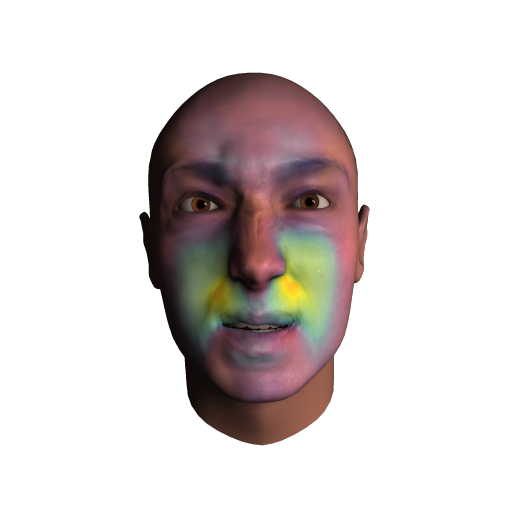

In [64]:
ctx.devmapwt = 1.
ctx.devmapmx = 12.
#ctx.devmapcm('inferno')
aus = ['AU9', 'AU25']
for au in aus:
    adata.bshapes[au] = 1
v_coeff = np.random.normal(0, 1, size=len(idm))
t_coeff = np.random.normal(0, 1, size=(idm.nbands, len(idm)))
nf = idm.generate(v_coeff, t_coeff, ethnicity='WC', gender='M', age=25,
                    basenf=base_nf)
nf.attach(ctx)  # attach to openGL context
img = ctx.render('image')

for au in aus:
    adata.bshapes[au] = 0.
img.save('dyn.png')
img

In [65]:
img = ctx.render('image')
img_ = np.array(img)
bg = np.ones((512, 512, 3)) * 255.
img_a = (img_[:, :, 3] / 255)[..., None]
img_ = (img_[:, :, :3] * img_a) + (bg * (1 - img_a))
img = Image.fromarray(img_.astype(np.uint8))
img.save('base.png')

In [66]:
ctx.devmapwt = 0.
anim = AnimController.zeros(adata=adata,nf=nf,fps=30)
crv = anim[0]
for au in aus:
    # set to [1, .5, .5, .5, .5, .5]
    crv.pr[au] = [1, *[.5]*5]
crv.eval_params()
anim.frame_source = 'next'

anim.loop = False

with VideoWriter('./test.mp4', 30) as vidobj:
    anim.rewind()

    while anim.step():
        img = ctx.render('image')
        img_ = np.array(img)
        bg = np.ones((512, 512, 3)) * 255.
        img_a = (img_[:, :, 3] / 255)[..., None]
        img_ = (img_[:, :, :3] * img_a) + (bg * (1 - img_a))
        img = Image.fromarray(img_.astype(np.uint8))
        vidobj.addframe(img)
                
    vidobj.write()